# Gender, Mental Illness, and Crime in the United States, 2004 Analysis

## Instalacja bibliotek

In [1]:
!pip install -r requirements.txt

## Sprawdzenie czy dane są dostępne

In [2]:
import os

file_path = os.path.join(os.getcwd(), 'ICPSR_27521-V1', 'ICPSR_27521', 'DS0001', '27521-0001-Data.tsv')
if not os.path.exists(file_path):
    raise FileNotFoundError(f'{file_path} nie został znaleziony\n Sprawdź ścieżkę')

## Wczytanie danych

In [3]:
import pandas as pd
df = pd.read_csv(file_path, sep='\t', low_memory=False)

Sprawdzenie wymiarów zbioru danych

In [4]:
print(df.shape[0], 'rzędów')
print(df.shape[1], 'kolumn')

55602 rzędów
3011 kolumn


Przetestowałem wykorzystanie dataframe z biblioteki `dask`, ale większość poleceń poza wczytywaniem była znacząco dłuższa (wykorzystanie `.compute()` dla wczytanego dataframe zajmowało 2-3x więcej czasu niż wczytanie przy pomocy `pandas`)

## Wstępna analiza

### Cecha do predykcji

Jako cecha do predykcji wybrana została kolumna `MDEYR`, która opisuje czy u respondenta w ostatnim roku wystąpił silny epizod depresyjny. Kolumna `DEPRESSIONINDEX` została odrzucona, ponieważ autorzy dodali przy niej komentarz `don’t use this one` (strona 1530 w Codebook), a dla wskaźnika `DEPRESSIONINDEX2` brakuje 93.2% danych. Z tego względu zadanie predykcji będzie zadaniem klasyfikacji, a nie regresji.

Pierwszym krokiem jest sprawdzenie ile jest brakujących danych w kolumnie `MDEYR`. Na podstawie Codebook poszczególne wartości w tej kolumnie oznaczają:
- `1` - respondent miał silny epizod depresyjny w ostatnim roku,
- `2` - respondent nie miał silnego epizodu depresyjnego w ostatnim roku,
- `3` - respondent poza zakresem - oznacza to, że był w próbce osób, które nie otrzymały pytań na temat zrowia psychicznego,
- `-9` - brak danych.

Na tej podstawie respondenci, dla których pojawiła się wartość `3` lub `-9` zostaną odrzuceni, ponieważ nie byłoby możliwości ich wykorzystania w uczeniu ze względu na brak ground truth. W innym przypadku mógłby to być zbiór testowy.

In [5]:
print(df['MDEYR'].value_counts())

num_of_missing_data = df['MDEYR'].value_counts()[-9] + df['MDEYR'].value_counts()[3]
print(num_of_missing_data, 'rzędów z brakującymi danymi')
print(df.shape[0] - num_of_missing_data, 'rzędów bez brakujących danych')

MDEYR
 2    33026
 3    18630
 1     3506
-9      440
Name: count, dtype: int64
19070 rzędów z brakującymi danymi
36532 rzędów bez brakujących danych


In [6]:
df = df[~df['MDEYR'].isin([-9, 3])]
df = df.reset_index(drop=True)
print(df.shape[0], 'rzędów po usunięciu brakujących danych')
# Reset index

36532 rzędów po usunięciu brakujących danych


Po usunięciu brakujących danych, rozkłąd wartości wygląda następująco.

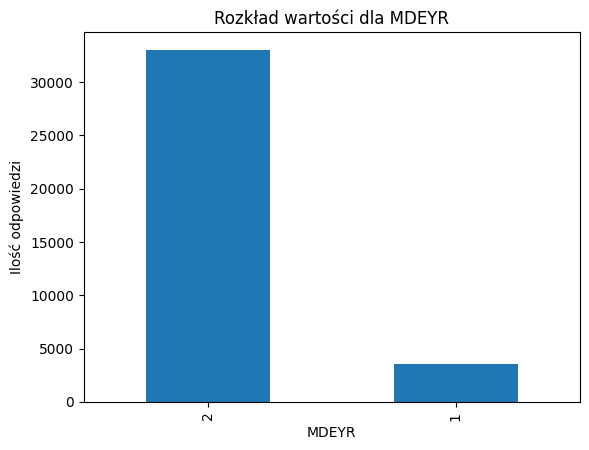

In [7]:
import matplotlib.pyplot as plt
df['MDEYR'].value_counts().plot(kind='bar')
plt.title('Rozkład wartości dla MDEYR')
plt.xlabel('MDEYR')
plt.ylabel('Ilość odpowiedzi')
plt.show()

Na rysunku powyżej widać, że większość respondentów odpowiedziała, że w ostatnim roku nie miała silnego stanu depresyjnego.

Uutworzona zostanie również nowa kolumna `DEPRESSIONTYPELASTYR`, która przyjmie następujące wartości:
    - `0`: brak depresji,
    - `1`: 'czysta' depresja,
    - `2`: depresja somatyczna;
Do jej powstania wykorzystane zostaną kolumny:
    - czy wystąpił silny epizod depresyjny w ostatnim roku `MDEYR`,
    - przy stanach depresyjnych zmmiany apetytu u dorosłych `AD_MDEA3` i młodzieży `YO_MDEA3`,
    - przy stanach depresyjnych problemy ze snem u dorosłych `AD_MDEA4` i młodzieży `YO_MDEA4`,
    - przy stanach depresyjnych poczucie zmęczenia u dorosłych `AD_MDEA6` i młodzieży `YO_MDEA6`.
  
Następnym krokiem jest utworzenie nowej kolumny i dodanie informacji o symptomach.

In [8]:
def depression_type(row):
    if row['MDEYR'] == 1 and row['YO_MDEA3'] == 1 and row['YO_MDEA4'] == 1 and row['YO_MDEA6'] == 1:
        return 2
    elif row['MDEYR'] == 1 and row['AD_MDEA3'] == 1 and row['AD_MDEA4'] == 1 and row['AD_MDEA6'] == 1:
        return 2
    elif row['MDEYR'] == 1:
        return 1
    else:
        return 0
    
df['DEPRESSIONTYPELASTYR'] = df.apply(depression_type, axis=1)

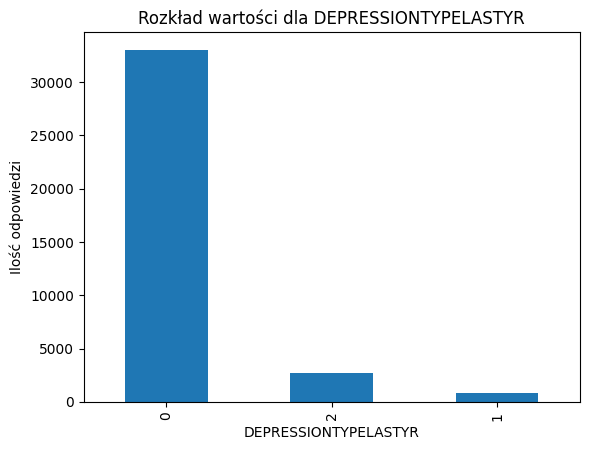

In [9]:
df['DEPRESSIONTYPELASTYR'].value_counts().plot(kind='bar')
plt.title('Rozkład wartości dla DEPRESSIONTYPELASTYR')
plt.xlabel('DEPRESSIONTYPELASTYR')
plt.ylabel('Ilość odpowiedzi')
plt.show()

Jak widać, większość osób, które miały silny epizod depresyjny miały również 3 symptomy somatyczne.

Ostateczna predykcja będzie 2 stopniowa:
- poziom 1: predykcja czy osoba miała silny stan depresyjny w ostatnim roku,
- poziom 2: wykorzystując poziom 1 nastąpi predykcja czy była to depresja 'bezobjawowa' czy somatyczna.

### Wybór i czyszczenie cech

Po przejrzeniu następujących artykułów:
- Silverstein, Brett; Levin, Eitan, "Differences in the developmental
patterns of depression with and without additional somatic symptoms."
Psychiatry Research. Dec 2014, 220, (1-2), 254 - 257. DOI:
10.1016/j.psychres.2014.07.054
- Thompson, Melissa, "Gender, Mental Illness, and Crime." Final Technical
Report. NCJ 224028, Sep 2008. 2007-IJ-CX-0004

oraz przeszukaniu Codebook, do wstępnej analizy wybrane zostały następujące cechy:
- płeć: `IRSEX`,
- wiek: `CATAG7`,
- współczynnik uzależnienia od narkotyków: `ANYINDEX`,
- kiedy ostatnio brał jakiekolwiek nielegalne narkotyki: `ANYILLICITRC`,
- czy używał marichuany/kokainy w ostatnim roku: `MJCOKELY`
- czy kiedykolwiek użył środków przeciwbólowych do celów niemedycznych: `ANLEVER`,
- czy popełnił przestępstwo: `ANYCRIME`,
- czy kiedykolwiek został aresztowany: `CRIMEHIST`,
- czy pracuje lub chodzi do szkoły: `WORKSCHOOL`,
- poziom edukacji: `IREDUC2`,
- ogólny poziom zdrowia: `HEALTH2`,
- czy respondent ma jakiekolwiek ubezpieczenie zdrowotne: `ANYHLTI2`,
- stan cywilny: `IRMARIT`,
- typ mieszkania: `CACHAR`,
- dochód rodziny: `INCOME`,
- uzależnienie od narkotyków lub alkoholu w ostatnim roku: `DPILLALC`,
- nadużywanie alkoholu w ostatnim roku: `ABUSEALC`,
- gęstość zaludnienia: `REVERSEPOP`.

In [10]:
columns_to_use = [
    'MDEYR',
    'DEPRESSIONTYPELASTYR',
    'IRSEX',
    'CATAG7',
    'ANYINDEX',
    'ANYILLICITRC',
    'MJCOKELY',
    'ANLEVER',
    'ANYCRIME',
    'CRIMEHIST',
    'WORKSCHOOL',
    'IREDUC2',
    'HEALTH2',
    'ANYHLTI2',
    'IRMARIT',
    'CACHAR',
    'INCOME',
    'DPILLALC',
    'ABUSEALC',
    'REVERSEPOP'
]

df = df[columns_to_use]

W niektórych z kolumn wartości wymagają ręcznego poprawienia, ponieważ zostały dobrane w sposób, który mógłby utrudnić analizę.

In [11]:
values_to_replace = {
    'ANYILLICITRC': [[9, 4]],
    'ANLEVER': [[81, 0], [91, 0]],
    'IRMARIT': [[99, 5]]
}

In [12]:
for column, values in values_to_replace.items():
    for value in values:
        df[column] = df[column].replace(value[0], value[1])

Słownik z oznaczeniami brakujących danych w poszczególnych kolumnach

In [13]:
missing_values = {
    'IRSEX': [],
    'CATAG7': [],
    'ANYINDEX': [-1],
    'ANYILLICITRC': [],
    'MJCOKELY': [],
    'ANLEVER': [97, 98],
    'ANYCRIME': [-1],
    'CRIMEHIST': [-1],
    'WORKSCHOOL': [-1],
    'IREDUC2': [],
    'HEALTH2': [-9],
    'ANYHLTI2': [94, 97, 98],
    'IRMARIT': [],
    'CACHAR': [-9],
    'INCOME': [],
    'DPILLALC': [],
    'ABUSEALC': [],
    'REVERSEPOP': []    
}

Obliczenie ilości brakujących danych w każdej kolumnie (i procentowego udziału)

In [14]:
indices_with_missing_data = []

for column, missing_values_list in missing_values.items():
    mask = df[column].isin(missing_values_list)
    num_of_missing_data = mask.sum()
    print(f'{column}: {num_of_missing_data} ({num_of_missing_data / df.shape[0] * 100:.2f}%)')
    indices_with_missing_data.extend(df[mask].index.to_list())

IRSEX: 0 (0.00%)
CATAG7: 0 (0.00%)
ANYINDEX: 25 (0.07%)
ANYILLICITRC: 0 (0.00%)
MJCOKELY: 0 (0.00%)
ANLEVER: 134 (0.37%)
ANYCRIME: 21 (0.06%)
CRIMEHIST: 74 (0.20%)
WORKSCHOOL: 4 (0.01%)
IREDUC2: 0 (0.00%)
HEALTH2: 10 (0.03%)
ANYHLTI2: 327 (0.90%)
IRMARIT: 0 (0.00%)
CACHAR: 7 (0.02%)
INCOME: 0 (0.00%)
DPILLALC: 0 (0.00%)
ABUSEALC: 0 (0.00%)
REVERSEPOP: 0 (0.00%)


Jeżeli w jakimś rzędzie brakuje przynajmniej 2 wartości to zostanie on usunięty

In [15]:
from collections import Counter
index_counts = Counter(indices_with_missing_data)
indices_to_remove = [index for index, count in index_counts.items() if count >= 2]

print(indices_to_remove)
df = df.drop(indices_to_remove)
df = df.reset_index(drop=True)

[11160, 33603, 18284, 24234, 25274, 32562, 23890, 30175, 34604, 10587]


Sprawdzenie typów wartości w poszczególnych kolumnach

In [16]:
print(df.info())
int64_columns = df.select_dtypes(include=['int64']).columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36522 entries, 0 to 36521
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MDEYR                 36522 non-null  int64  
 1   DEPRESSIONTYPELASTYR  36522 non-null  int64  
 2   IRSEX                 36522 non-null  int64  
 3   CATAG7                36522 non-null  int64  
 4   ANYINDEX              36522 non-null  float64
 5   ANYILLICITRC          36522 non-null  int64  
 6   MJCOKELY              36522 non-null  int64  
 7   ANLEVER               36522 non-null  int64  
 8   ANYCRIME              36522 non-null  int64  
 9   CRIMEHIST             36522 non-null  int64  
 10  WORKSCHOOL            36522 non-null  int64  
 11  IREDUC2               36522 non-null  int64  
 12  HEALTH2               36522 non-null  int64  
 13  ANYHLTI2              36522 non-null  int64  
 14  IRMARIT               36522 non-null  int64  
 15  CACHAR             

In [17]:
print(df['ANYINDEX'].nunique())

13


Ze względu na fakt, że kolumna `ANYINDEX` posiada wartości typu `float64`, gdzie jest 12 unikalnych wartości (trzynasta oznacza braki), to dla ułatwienia wiersze, w których brakuje wartości w tej kolumnie, zostaną usunięte. 

In [18]:
df = df[df['ANYINDEX'] != -1]
df = df.reset_index(drop=True)

Pozostałe brakujące wartości zostaną uzupełnione przy pomocy metody KNN

In [19]:
# Use KNN Imputer to fill missing values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=11)
df_imputed = imputer.fit_transform(df)

In [20]:
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
df_imputed[int64_columns] = df_imputed[int64_columns].astype('int64')

In [21]:
df = df_imputed

### Analiza czynników wpływających na występowanie depresji